In [27]:
%matplotlib inline
from IPython.display import Image
%config InlineBackend.figure_format = 'svg'
# export slides with command "jupyter nbconvert run_haats.ipynb --to slides --post serve" in terminal
from import_data import *
from estimation import *
np.random.seed(222)
plt.close("all")
from matplotlib import rc

# On fancy  <font color='grey'>H</font><font color='blue'>A</font><font color='green'>²</font><font color='red'>T</font><font color='purple'>S</font>
![title](/output/figures/queen_hat.jpg) 


### An introduction to <font color='grey'>H</font>idden-state <font color='blue'>A</font>rbitrage-free <font color='green'>A</font>ffine  <font color='red'>T</font>erm <font color='purple'>S</font>tructure (<font color='grey'>H</font><font color='blue'>A</font><font color='green'>A</font><font color='red'>T</font><font color='purple'>S</font>) models




#### Author: Serginio &#8220;Gino&#8221; Sylvain 

## How do we know when to go long/short Break-Even’s (Nominal Bonds vs ILBs) ?





## What is the market-implied inflation rate?





## How can we extract the term premium from using a theoretical/structural model?



### We often use the Break-Even rate (BE = Nominal Yield - TIPS Yield) as an estimate of expected inflation

![title](/output/figures/fred_bkeven.jpg) 

For example: if Break-Evens (BE) come down quite a bit, what is that? Should we go long or short Break-evens (by trading ILB’s and short Nominal Bonds or using derivatives)?



But  wait…. BE = Exp. Inf. + IRP

* Perhaps shorting BE’s is more attractive if Exp. Inf. implied by BE’s is “too low”


* If instead, it is the IRP that is low (or negative) and dragging BE’s down, then it may be reflecting that investors  expect  future inflation to coincide with a period of higher income growth and/or that nominal yields are coming down sharply due to safe haven flows 


* In general, Exp. Inf. and IRP implied by BE  can help inform our investment decisions


## Methodology

### <font color='grey'>H</font><font color='blue'>A</font><font color='green'>²</font><font color='red'>T</font><font color='purple'>S</font> ingredients: model replicates / is heavily inspired by the  series of papers by Christensen – Diebold – Lopez – Rudebusch (2007, 2010, 2013)

## Data

Importing and cleaning up (Nelson Siegel smoothed/fitted) yield data for TIPS and Nominal bonds...

Data source:

http://www.federalreserve.gov/econresdata/researchdata/feds200628.xls

https://www.federalreserve.gov/econresdata/researchdata/feds200805.xls

In [3]:
# Import data from FED and doing some cleaning
tips_data, nominal_data = ImportData.importUS_Data(plots=1,save=1)

            TIPSY02  TIPSY03  TIPSY04  TIPSY05  TIPSY06  TIPSY07  TIPSY08  \
1999-01-04      NaN      NaN      NaN   3.9244   3.9369   3.9310   3.9170   
1999-01-05      NaN      NaN      NaN   3.9385   3.9525   3.9475   3.9340   
1999-01-06      NaN      NaN      NaN   3.8522   3.8357   3.8182   3.8026   
1999-01-07      NaN      NaN      NaN   3.8995   3.8827   3.8550   3.8282   
1999-01-08      NaN      NaN      NaN   3.9043   3.8985   3.8771   3.8525   

            TIPSY09  TIPSY10  TIPSY11  TIPSY12  TIPSY13  TIPSY14  TIPSY15  \
1999-01-04   3.9002   3.8832   3.8673   3.8527   3.8397   3.8281   3.8179   
1999-01-05   3.9175   3.9005   3.8845   3.8698   3.8566   3.8449   3.8345   
1999-01-06   3.7893   3.7783   3.7691   3.7613   3.7547   3.7490   3.7441   
1999-01-07   3.8051   3.7859   3.7698   3.7562   3.7448   3.7349   3.7264   
1999-01-08   3.8293   3.8089   3.7913   3.7762   3.7633   3.7521   3.7424   

            TIPSY16  TIPSY17  TIPSY18  TIPSY19  TIPSY20  
1999-01-04   3.8

In [4]:
fig, ax = plt.subplots(1)
figures = {'fig1': fig, 'ax_fig1': ax}
nominal_data.plot(ax=figures['ax_fig1'],figsize=(8,8))
plt.legend(loc='center left',fontsize=9,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig1'].set_title('US Nominal Bonds')
plt.show()

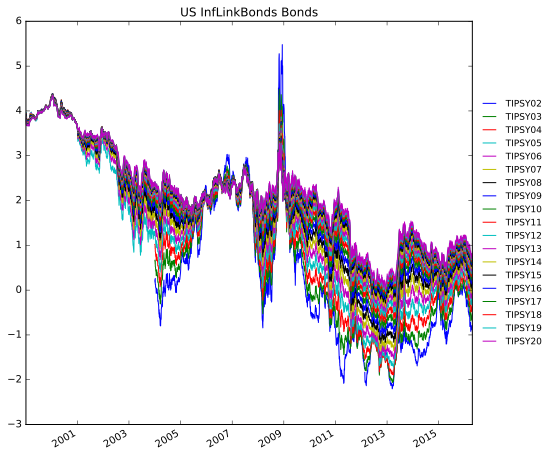

In [5]:
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
tips_data.plot(ax=figures['ax_fig2'],figsize=(8,8))
plt.legend(loc='center left',fontsize=9,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('US InfLinkBonds Bonds')
plt.show()

## Estimation

In [12]:
start_time = time.time()

# The interveal between each rolling window: the gap by which the estimationd window shifts 
# (e.g. with tgap = 1, rolling window is updated daily)
tgap = 30 

# Rolling window: 0 if using expanding window, 1 if using rolling window
rolling = 0 

#Rolling window size: size of rolling window (in years).. Use inf for full sample estimation
windowsize = np.inf;

np.set_printoptions(precision=32, suppress=True) #increase precision on  numeric values

# global variables
global a, Kp, lmda,lmda2,  Phi, sigma11, sigma22, sigma22_2, sigma33, sigma33_2,\ 
    sigma44, Sigma, thetap, Nfeval, figures, cum_log_likelihood,\
    Nfeval_vec, cum_log_likelihood_vec, doc, Nfeval_inner

    
################################################

# PRIMITIVES:
figures = []
# use allow_missing_data= 1 to extract ILB and Nominal dates where both are non-missing
allow_missing_data = 0 

# set frequency of the data: daily, monthly, quarterly, yearly
estim_freq = 'daily'  

fix_Phi = 0     # "1" if you want to fix the volatility of observed yields using covar of historical data
                # "0" if you want to jointly estimate it with other model parameters
setdiag_Kp = 0  # "1" if you want to Kp to be diagonal so the state variables are assumed independent
                # "0" if you want to Kp to be unrestricted

# options for initializing the Kalman filter error variance: 
#'steady_state' or 'unconditional' or 'identity' matrix
initV = 'unconditional' 
    
# number of hidden state variables 4, or 6
num_states = 4      

# Specify the maturities of data we want to use
US_ilbmaturities = np.array([2, 3,  5, 6, 8, 9, 10])
US_nominalmaturities = np.array([2, 3,  5, 6, 8, 9, 10])
US_maturities = np.hstack((US_nominalmaturities, US_ilbmaturities))

############################################################

# Set start and end dates for estimation
sdate, edate = '2004-01-01', '2010-01-01'
print("start date: %s" % sdate)
print("end date: %s" % edate)

# extract data for desired maturities and dates
tips_data, nominal_data = ImportData.importUS_Data(US_ilbmaturities, US_nominalmaturities)
data = ImportData.extract_subset(tips_data, nominal_data, sdate, edate, allow_missing_data, estim_freq)

estimation =Rolling()
estimation.run(data, US_ilbmaturities, US_nominalmaturities, \
                estim_freq=estim_freq, num_states=num_states,\
                fix_Phi=fix_Phi, setdiag_Kp=setdiag_Kp, initV=initV )

end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))


SyntaxError: unexpected character after line continuation character (<ipython-input-12-f58c04d453eb>, line 16)

In [8]:
tips_data[np.array(['TIPSY02','TIPSY03'])]

TIPSY02  TIPSY03
1999-01-04      NaN      NaN
1999-01-05      NaN      NaN
1999-01-06      NaN      NaN
1999-01-07      NaN      NaN
1999-01-08      NaN      NaN
1999-01-11      NaN      NaN
1999-01-12      NaN      NaN
1999-01-13      NaN      NaN
1999-01-14      NaN      NaN
1999-01-15      NaN      NaN
1999-01-19      NaN      NaN
1999-01-20      NaN      NaN
1999-01-21      NaN      NaN
1999-01-22      NaN      NaN
1999-01-25      NaN      NaN
1999-01-26      NaN      NaN
1999-01-27      NaN      NaN
1999-01-28      NaN      NaN
1999-01-29      NaN      NaN
1999-02-01      NaN      NaN
1999-02-02      NaN      NaN
1999-02-03      NaN      NaN
1999-02-04      NaN      NaN
1999-02-05      NaN      NaN
1999-02-08      NaN      NaN
1999-02-09      NaN      NaN
1999-02-10      NaN      NaN
1999-02-11      NaN      NaN
1999-02-12      NaN      NaN
1999-02-16      NaN      NaN
...             ...      ...
2016-03-11  -0.5515  -0.3203
2016-03-14  -0.5198  -0.2899
2016-03-15  -0.4894  -0.2604
2016-03-16  -0.6952  -0.4552
2016-03-17  -0.7568  -0.4951
2016-03-18  -0.8118  -0.5553
2016-03-21  -0.8130  -0.5551
2016-03-22  -0.7766  -0.5010
2016-03-23  -0.7545  -0.4894
2016-03-24  -0.7245  -0.4468
2016-03-28  -0.7199  -0.4483
2016-03-29  -0.8392  -0.5857
2016-03-30  -0.9054  -0.6607
2016-03-31  -0.9212  -0.6884
2016-04-01  -0.8774  -0.6493
2016-04-04  -0.8745  -0.6582
2016-04-05  -0.8374  -0.6381
2016-04-06  -0.8446  -0.6305
2016-04-07  -0.8588  -0.6590
2016-04-08  -0.8881  -0.6687
2016-04-11  -0.8735  -0.6489
2016-04-12  -0.8524  -0.6064
2016-04-13  -0.8523  -0.6104
2016-04-14  -0.7938  -0.5670
2016-04-15  -0.8287  -0.5601
2016-04-18  -0.8019  -0.5379
2016-04-19  -0.8249  -0.5659
2016-04-20  -0.8065  -0.5378
2016-04-21  -0.7867  -0.5138
2016-04-22  -0.8065  -0.5186

[4349 rows x 2 columns]

## Kalman filter example

In [69]:
#Assign model parameters
T_=100
m=14
A0, A1, U0, U1, Q, Phi = np.mat(np.random.randn(m, 1)), np.mat(np.random.randn(m, 4)), \
                            np.mat(np.random.randn(4, 1)), np.mat(np.diag(np.diag(np.random.rand(4, 4)))), \
                            np.mat(np.diag(np.diag(np.random.rand(4, 4)))), np.mat(np.diag(np.diag(np.random.rand(m, m))))

In [70]:

#Assign state variables (X) and the measurement (Ys)
X0 = np.mat(np.random.randn(4,1))
X = np.mat(np.empty((T_,4))*np.nan)
Y = np.mat(np.empty((T_,m))*np.nan)
for t in range(T_):
    if t==0:
        X[t,:] = (U0+U1*X0+Q*np.mat(np.random.randn(4,1))).T
    else:   
        X[t,:] = (U0+U1*X[t-1,:].T +Q*np.mat(np.random.randn(4,1))).T
    Y[t,:] = (A0+A1*X[t,:].T+Phi*np.mat(np.random.randn(m,1))).T

X_df= pd.DataFrame(np.array(X),
                columns=['LN', 'S', 'C', 'LR'], index=pd.date_range('2000-01-01', periods=X.shape[0]))
Y_df= pd.DataFrame(np.array(Y),
                columns=['yield_'+str(i) for i in range(14)], index=pd.date_range('2000-01-01', periods=X.shape[0]))

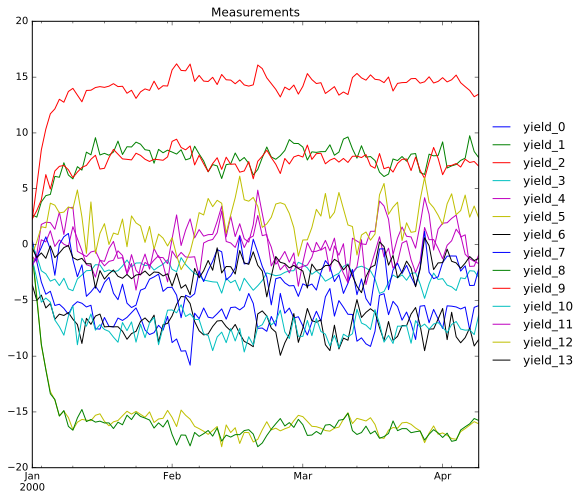

In [71]:
plt.rc('text', usetex=False)
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
Y_df.plot(ax=figures['ax_fig2'],figsize=(8,8))
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Measurements')
plt.show()


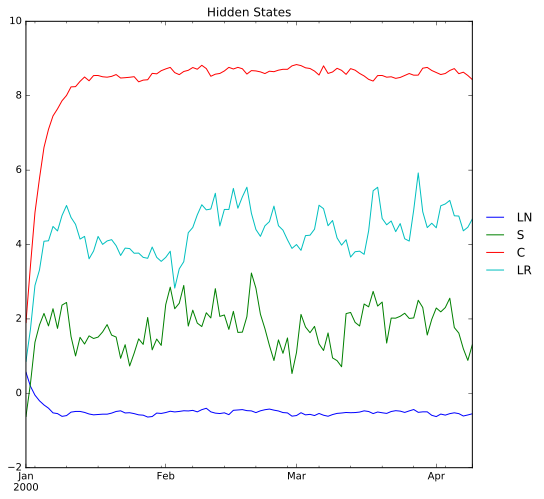

In [72]:
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
X_df.plot(ax=figures['ax_fig2'],figsize=(8,8))
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Hidden States')
plt.show()

In [73]:
kalman = Kalman(Y_df, A0, A1, U0, U1, Q, Phi,statevar_names = X_df.columns.values)
Ytt_filtered, Yttl_filtered, Xtt_filtered, Xttl_filtered, Vtt, Vttl, Gain_t, eta_t_filtered, cum_log_likelihood = kalman.filter()



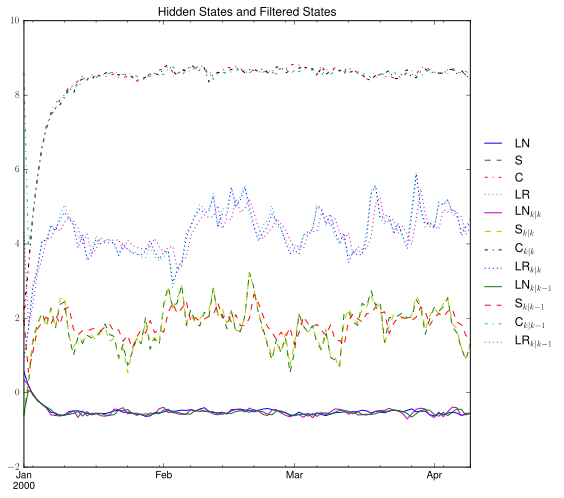

In [75]:
linestyles = ['-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':']

plt.rc('text', usetex=True)
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
pd.concat(
    [X_df,
    Xtt_filtered.rename(columns={i:i+'$_{k|k}$' for i in Xtt_filtered.columns.values},inplace=False),
    Xttl_filtered.rename(columns={i:i+'$_{k|k-1}$' for i in Xtt_filtered.columns.values},inplace=False)]
, axis=1).plot(ax=figures['ax_fig2'],figsize=(8,8),style=linestyles)
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Hidden States and Filtered States')
plt.show()

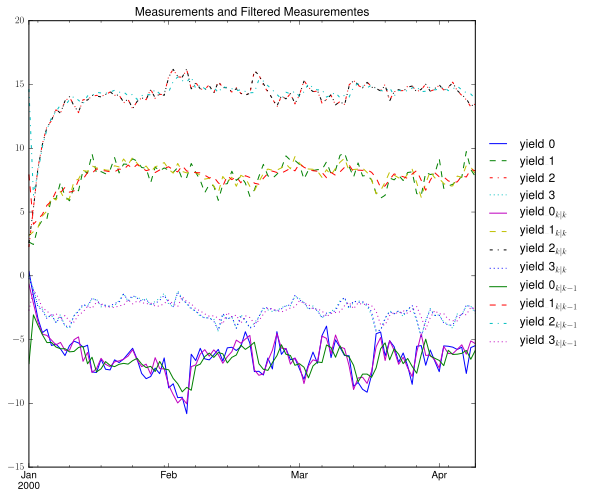

In [74]:
linestyles = ['-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':','-', '--', '-.', ':']
plt.rc('text', usetex=True)
fig, ax = plt.subplots(1)
figures = {'fig2': fig, 'ax_fig2': ax}
pd.concat(
    [Y_df.iloc[:,0:4].rename(columns={i:str.replace(i,'_','\_') for i in Y_df.columns.values},inplace=False),
    Ytt_filtered.iloc[:,0:4].rename(columns={i:str.replace(i,'_','\_')+'$_{k|k}$' for i in Ytt_filtered.columns.values},inplace=False),
    Yttl_filtered.iloc[:,0:4].rename(columns={i:str.replace(i,'_','\_')+'$_{k|k-1}$' for i in Yttl_filtered.columns.values},inplace=False)]
, axis=1).plot(ax=figures['ax_fig2'],figsize=(8,8),style=linestyles)
plt.legend(loc='center left',fontsize=12,frameon=0, bbox_to_anchor=(1, 0.5))
figures['ax_fig2'].set_title('Measurements and Filtered Measurementes')
plt.show()